 #  Transfer learning model- NASNet:Neural Architecture Search Network (Intel Scene Multi-Class Image Classification)


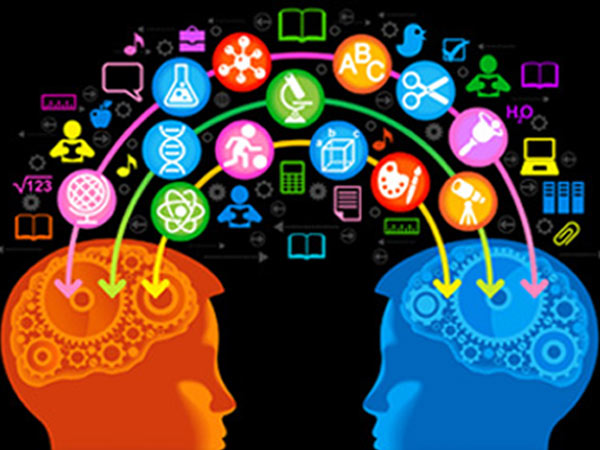

Identifying natural scenes from all around the world is an interesting computer vision problem. In this challenge, we are going to classify six different category Imges.This dataset contains about ~25k images from a wide range of natural scenes from all around the world. The task is to identify which kind of scene can the image be categorized into.

It is a 6 class problem

- Buildings
-Forests
-Mountains
- Glacier
- Street
- Sea


## Content

This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

If you check the directory under input (check the top right portion of this notebook), you can see that images are placed inside their respective classes. Separate class label csv file is not given.

So we have two choices
  1. Load images directly from ImageDataGenerator.flow_from_directory
  2. Create a function to load images from directory and create a list for class lables 

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrvmurali","key":"b52d02bd18b2eed468ba2144e5ad2c6b"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d puneet6060/intel-image-classification

 95% 330M/346M [00:03<00:00, 74.8MB/s]
100% 346M/346M [00:03<00:00, 92.9MB/s]


## Given data is in Zip format. So first we have to unzip the files

In [7]:
!unzip "/content/intel-image-classification.zip"

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

## Import the libraries:

In [8]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,load_img
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential,Model, load_model
from keras.optimizers import Adam,SGD 
from keras.callbacks import ReduceLROnPlateau 
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout
import warnings
warnings.filterwarnings("ignore")

##Visualize some Random Images from Training set

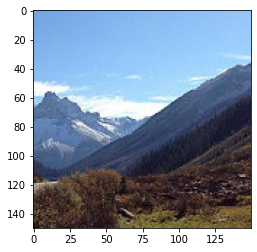

In [9]:
image = load_img("/content/seg_train/seg_train/mountain/10008.jpg")
plt.imshow(image)

## Transforms for image -augmentations


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,horizontal_flip=True,shear_range=0.2,  
    zoom_range=0.2, validation_split=0.2)

train_generator=train_datagen.flow_from_directory(
      '/content/seg_train/seg_train',
      target_size=(224, 224),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='training'
    
)

validation_generator=train_datagen.flow_from_directory(
      '/content/seg_train/seg_train',
      target_size=(224, 224),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='validation'
    
)

test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_directory(
    "/content/seg_test/seg_test", 
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    seed=2209
) 


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [11]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [12]:
#mapping encoded values to class labels
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

## Generator work

In [13]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

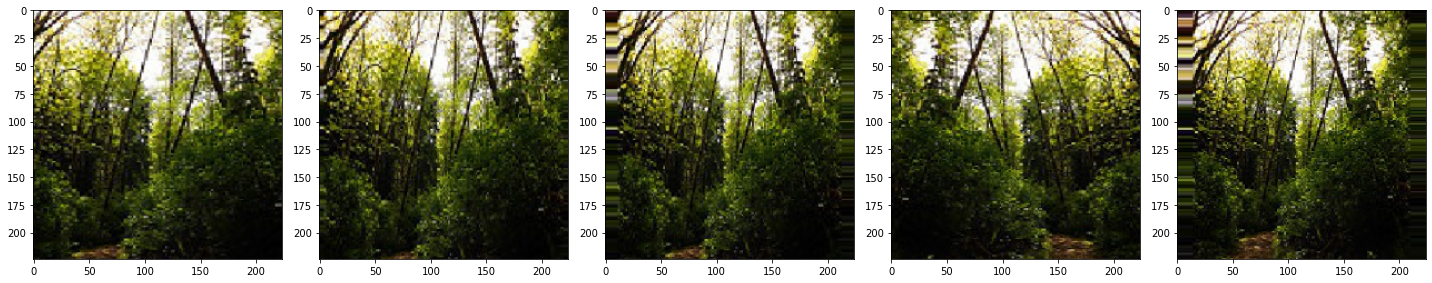

In [14]:
images = [train_generator[0][0][0] for i in range(5)]
plotImages(images)

## NASNet

NASNet, by Google Brain, is reviewed. Authors propose to search for an architectural building block on a small dataset and then transfer the block to a larger dataset. Particularly, they search for the best convolutional layer or cell on CIFAR-10 first, then apply this cell to the ImageNet by stacking together more copies of this cell. A new regularization technique called ScheduledDropPath is also proposed which significantly improves the generalization in the NASNet models. At last, NASNet model achieves state-of-the-art results with smaller model size and lower complexity (FLOPs).

- In NASNet, though the overall architecture is predefined as shown above, the blocks or cells are not predefined by authors. 
- Instead, they are searched by reinforcement learning search method.
- i.e. the number of motif repetitions N and the number of initial convolutional filters are as free parameters, and used for scaling.
- Specifically, these cells are called Normal Cell and Reduction Cell.
Normal Cell: Convolutional cells that return a feature map of the same dimension.
- Reduction Cell: Convolutional cells that return a feature map where the feature map height and width is reduced by a factor of two.
- Only the structures of (or within) the Normal and Reduction Cells are searched by the controller RNN (Recurrent Neural Network).

## 1. Neural Architecture Search (NAS) for Cells


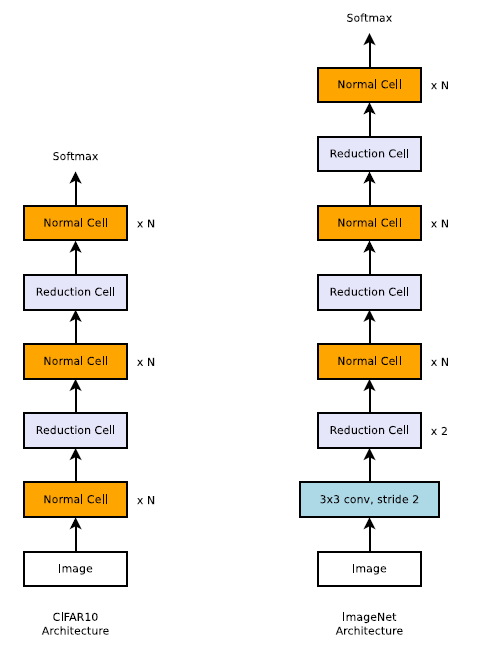

- In NASNet, though the overall architecture is predefined as shown above, the blocks or cells are not predefined by authors. 
- Instead, they are searched by reinforcement learning search method.
- i.e. the number of motif repetitions N and the number of initial convolutional filters are as free parameters, and used for scaling.
- Specifically, these cells are called Normal Cell and Reduction Cell.
Normal Cell: Convolutional cells that return a feature map of the same dimension.
- Reduction Cell: Convolutional cells that return a feature map where the feature map height and width is reduced by a factor of two.
- Only the structures of (or within) the Normal and Reduction Cells are searched by the controller RNN (Recurrent Neural Network).

##2. Controller Model Architecture
## 3. NASNet-A, NASNet-B & NASNet-C

In [15]:
# Hyperparameters:
batch_size = 32
lr = 0.001
n_class = 6
epochs =20
adam = Adam(lr = lr, beta_1 = 0.9, beta_2 =0.999,amsgrad =False,epsilon =1e-7)

In [16]:
#ReduceLROnPlateau to reduce LR 
lrr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,factor =0.25,min_lr = 0.000003, verbose =1)

In [17]:
#Creating early stopping callback
from  keras.callbacks import EarlyStopping
early_stopping =EarlyStopping(monitor = 'val_accuracy', patience=3) 
#stop the training process if there is no change in val_accuracy for 3 rounds

In [18]:

# Import the model  
from tensorflow.keras.applications import NASNetMobile


pre_trained_model = NASNetMobile(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')


# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

19996672/19993432 [==============================] - 0s 0us/step
Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
____________________________

In [19]:
from tensorflow.keras import layers
x = layers.Dropout(0.3)(pre_trained_model.output)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.Dense(6, activation='softmax')(x)           
model = Model( pre_trained_model.input, x) 
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 10,893,850
Trainable params: 6,624,134
Non-trainable params: 4,269,716
__________________________________________________________________________________________________


In [20]:
history=model.fit_generator(
  train_generator,
  steps_per_epoch=int(11230/64),
  epochs=20,
  validation_data=validation_generator,
  validation_steps=int(2804/64),
  
  verbose=1
)

Epoch 1/20
175/175 [==============================] - 202s 869ms/step - loss: 1.4124 - accuracy: 0.7926 - val_loss: 0.3208 - val_accuracy: 0.8914
Epoch 2/20
175/175 [==============================] - 148s 848ms/step - loss: 0.2919 - accuracy: 0.9001 - val_loss: 0.3179 - val_accuracy: 0.8855
Epoch 3/20
175/175 [==============================] - 147s 842ms/step - loss: 0.2431 - accuracy: 0.9120 - val_loss: 0.2987 - val_accuracy: 0.8917
Epoch 4/20
175/175 [==============================] - 146s 840ms/step - loss: 0.2103 - accuracy: 0.9236 - val_loss: 0.3074 - val_accuracy: 0.8968
Epoch 5/20
175/175 [==============================] - 148s 851ms/step - loss: 0.2106 - accuracy: 0.9230 - val_loss: 0.3029 - val_accuracy: 0.9004
Epoch 6/20
175/175 [==============================] - 146s 838ms/step - loss: 0.2068 - accuracy: 0.9241 - val_loss: 0.3041 - val_accuracy: 0.8895
Epoch 7/20
175/175 [==============================] - 146s 837ms/step - loss: 0.1909 - accuracy: 0.9292 - val_loss: 0.2605 -

## Virtualize Training

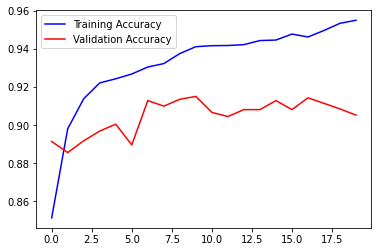

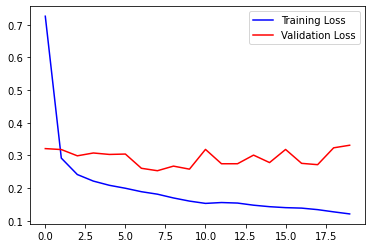

In [21]:
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(20) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

# Prepare Evaluate Generator for Model

In [22]:
accuracy=model.evaluate_generator(test_generator, steps=len(test_generator)//32,verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])

2/2 - 0s - loss: 0.1023 - accuracy: 0.9531
Accuracy of the model on the test set:  0.953125


# Test Model performance on custom data:

In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image

def pred(path):
  test_image = image.load_img(path, target_size = (224,224))
  plt.imshow(test_image)
  test_image=np.expand_dims(test_image,axis=0)
  test_image=np.array(test_image)
  test_image=test_image/255
  prediction =np.argmax(model.predict(test_image),axis=1)
  result={0: 'buildings',1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
  return print(result[prediction[0]])

forest


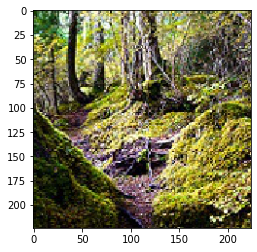

In [26]:
pred('/content/seg_pred/seg_pred/10021.jpg')

street


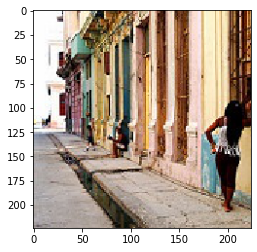

In [27]:
pred('/content/seg_pred/seg_pred/10045.jpg')

## NASNetLarge

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,horizontal_flip=True,shear_range=0.2,  
    zoom_range=0.2, validation_split=0.2)

train_generator=train_datagen.flow_from_directory(
      '/content/seg_train/seg_train',
      target_size=(331, 331),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='training'
    
)

validation_generator=train_datagen.flow_from_directory(
      '/content/seg_train/seg_train',
      target_size=(331, 331),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='validation'
    
)

test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_directory(
    "/content/seg_test/seg_test", 
    target_size=(331, 331),
    batch_size=32,
    class_mode='sparse',
    seed=2209
) 


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [29]:

# Import the model  
from tensorflow.keras.applications import NASNetLarge


pre_trained_model = NASNetLarge(input_shape = (331, 331, 3), 
                                include_top = False, 
                                weights = 'imagenet')


# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()
  

343613440/343610240 [==============================] - 4s 0us/step
Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 165, 165, 96) 0           stem_bn1[0][0]                   
__________________________

In [31]:
from tensorflow.keras import layers
x = layers.Dropout(0.3)(pre_trained_model.output)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.Dense(6, activation='softmax')(x)           
model = Model( pre_trained_model.input, x) 
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 147,365,336
Trainable params: 62,448,518
Non-trainable params: 84,916,818
__________________________________________________________________________________________________


In [32]:
history=model.fit_generator(
  train_generator,
  steps_per_epoch=int(11230/64),
  epochs=20,
  validation_data=validation_generator,
  validation_steps=int(2804/64),
  
  verbose=1
)

Epoch 1/20
175/175 [==============================] - 460s 3s/step - loss: 9.9463 - accuracy: 0.7810 - val_loss: 0.5552 - val_accuracy: 0.8463
Epoch 2/20
175/175 [==============================] - 443s 3s/step - loss: 0.5108 - accuracy: 0.8664 - val_loss: 0.5255 - val_accuracy: 0.8681
Epoch 3/20
175/175 [==============================] - 441s 3s/step - loss: 0.3332 - accuracy: 0.8924 - val_loss: 0.4126 - val_accuracy: 0.8932
Epoch 4/20
175/175 [==============================] - 441s 3s/step - loss: 0.2746 - accuracy: 0.9103 - val_loss: 0.3862 - val_accuracy: 0.8903
Epoch 5/20
175/175 [==============================] - 439s 3s/step - loss: 0.2325 - accuracy: 0.9261 - val_loss: 0.3625 - val_accuracy: 0.9026
Epoch 6/20
175/175 [==============================] - 439s 3s/step - loss: 0.2301 - accuracy: 0.9280 - val_loss: 0.3623 - val_accuracy: 0.9121
Epoch 7/20
175/175 [==============================] - 439s 3s/step - loss: 0.1809 - accuracy: 0.9379 - val_loss: 0.3171 - val_accuracy: 0.9146

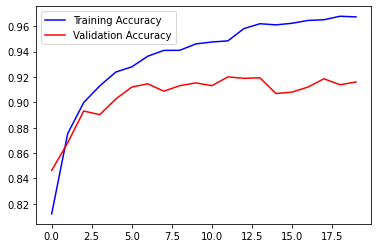

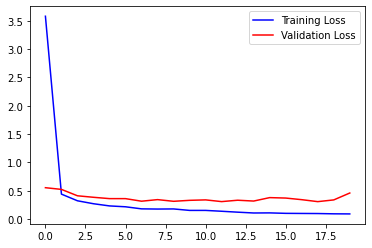

In [33]:
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(20) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

In [34]:
accuracy=model.evaluate_generator(test_generator, steps=len(test_generator)//32,verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])

2/2 - 3s - loss: 0.1481 - accuracy: 0.9375
Accuracy of the model on the test set:  0.9375
